# SWIFT SCORE #
## READMISSION PREDICTION
### SWIFT score of greater than 15 is correlated with an increased unplanned readmission risk.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import os
import random
from pathlib import Path

In [ ]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
PROCESSED_DATA = os.path.join(ROOT_FOLDER , "data", "processed")
ICU_STAYS = os.path.join(PROCESSED_DATA,"icustays_20240512.feather")
df1 = feather.read_feather(ICU_STAYS )
df1 = df1[['icu_stay_id','icu_los','subject_id']]
df1['icu_stay_id'] = df1['icu_stay_id'].astype(int)
df1.head()

In [3]:
os.chdir('/workspaces/xitaso')

In [ ]:
from src.data.mimic_iv import hosp

base_path = Path('/workspaces/xitaso/data/external/mimic-iv-2.2')
admissions_df = hosp.build_admissions(base_path=base_path)
print(admissions_df['admission_location'].unique())

In [ ]:
combined_df = pd.merge(admissions_df, df1, on='subject_id', how='left')
combined_df ['admittime'] = pd.to_datetime(combined_df['admittime'])
combined_df ['dischtime'] = pd.to_datetime(combined_df['dischtime'])
combined_df.head()

In [ ]:
ICU_TIMESERIES_FEATURES = os.path.join(PROCESSED_DATA,"icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
df2 = feather.read_feather(ICU_TIMESERIES_FEATURES )
df2 = df2[['abs_event_time', 'stay_id','pO2','pCO2','GCS - Eye Opening','O2 Flow','O2 saturation pulseoxymetry','GCS - Motor Response','GCS - Verbal Response']]
df2['abs_event_time'] = pd.to_datetime(df2['abs_event_time'])
df2.head()

In [ ]:
merged_df = pd.merge(combined_df, df2, left_on='icu_stay_id', right_on='stay_id', how='inner')
merged_df.head()

In [13]:
def calculate_swift_score(row, averages):
    swift_points = 0

    # Original source of ICU admission
    admission_location = row['admission_location'] if pd.notna(row['admission_location']) else averages['admission_location']
    if admission_location == "EMERGENCY ROOM" or "PACU" or "CLINIC REFERRAL" or "PHYSICIAN REFERRAL":
        swift_points += 0
    else:
        swift_points += 2

    # Total ICU length of stay
    icu_los = row['icu_los'] if pd.notna(row['icu_los']) else averages['icu_los']
    if icu_los < 2:
        swift_points += 0
    elif 2 <= icu_los <= 10:
        swift_points += 1
    elif icu_los > 10:
        swift_points += 14

    # Last measured O2 saturation pulseoxymetry
    o2_saturation_pulseoxymetry = row['O2 saturation pulseoxymetry'] if pd.notna(row['O2 saturation pulseoxymetry']) else averages['O2 saturation pulseoxymetry']
    if o2_saturation_pulseoxymetry >= 92:
        swift_points += 0
    elif 88 <= o2_saturation_pulseoxymetry < 92:
        swift_points += 5
    elif 85 <= o2_saturation_pulseoxymetry < 88:
        swift_points += 10
    elif o2_saturation_pulseoxymetry < 85:
        swift_points += 13

    # Glasgow coma scale at time of ICU discharge
    GCS_Eye_Opening = row['GCS - Eye Opening'] if pd.notna(row['GCS - Eye Opening']) else averages['GCS - Eye Opening']
    GCS_Motor_Response = row['GCS - Motor Response'] if pd.notna(row['GCS - Motor Response']) else averages['GCS - Motor Response']
    GCS_Verbal_Response = row['GCS - Verbal Response'] if pd.notna(row['GCS - Verbal Response']) else averages['GCS - Verbal Response']
    glasgow_coma_scale = 15 - (GCS_Eye_Opening + GCS_Motor_Response + GCS_Verbal_Response)
    if glasgow_coma_scale >= 14:
        swift_points += 24
    elif 11 <= glasgow_coma_scale < 14:
        swift_points += 14
    elif 8 <= glasgow_coma_scale < 11:
        swift_points += 6
    elif glasgow_coma_scale < 8:
        swift_points += 0

    # Last arterial blood gas PaCO2
    pCO2 = row['pCO2'] if pd.notna(row['pCO2']) else averages['pCO2']
    if pCO2 <= 45:
        swift_points += 0
    else:
        swift_points += 5

    return swift_points

# DataFrame `averages` dictionary
averages = {
    'admission_location': merged_df['admission_location'].mode()[0],  # Kategorik için mod
    'icu_los': merged_df['icu_los'].mean(),
    'O2 saturation pulseoxymetry': merged_df['O2 saturation pulseoxymetry'].mean(),
    'GCS - Eye Opening': merged_df['GCS - Eye Opening'].mean(),
    'GCS - Motor Response': merged_df['GCS - Motor Response'].mean(),
    'GCS - Verbal Response': merged_df['GCS - Verbal Response'].mean(),
    'pCO2': merged_df['pCO2'].mean()
}

In [14]:
merged_df['swift_score'] = merged_df.apply(lambda row: calculate_swift_score(row, averages), axis=1)

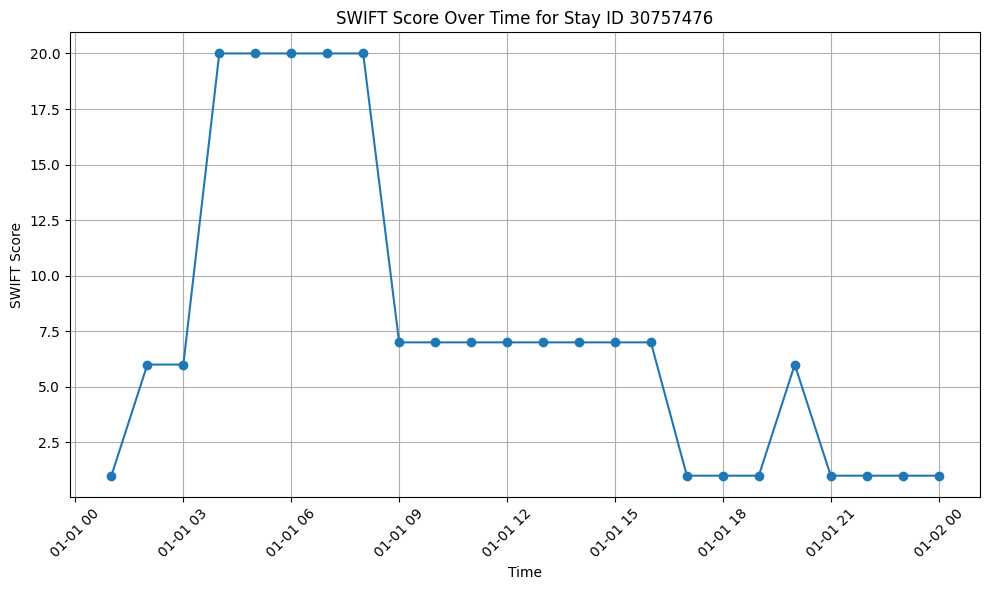

In [15]:
specific_stay_id = 30757476
# 31959184 34617352  31205490 37648963
filtered_data = merged_df[merged_df['stay_id'] == specific_stay_id]

# SWIFT score
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['abs_event_time'], filtered_data['swift_score'], marker='o')
plt.title(f'SWIFT Score Over Time for Stay ID {specific_stay_id}')
plt.xlabel('Time')
plt.ylabel('SWIFT Score')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [12]:
# Count unique icu_stay_ids with a SWIFT score above 15
unique_high_swift_score_count = merged_df[merged_df['swift_score'] > 15]['subject_id'].nunique()

print("Number of unique ICU Stay IDs with SWIFT score greater than 15:", unique_high_swift_score_count)

Number of unique ICU Stay IDs with SWIFT score greater than 15: 19
